# Fitting Step Test Data to Empirical Models

> **Objectif de ce notebook :** nous allons analyser la réponse à un échelon de puissance réalisé précédemment. Nous allons tenter d'identifier les modèles présenter une réponse proche : 1er ordre, 1er ordre avec retard et second ordre. 

> **Exercise:** write a code cell that turns on heater 1 at 50% power, then log the temperature responses (T1 and T2) once per second for 600 seconds. The output of the cell should report the time, power level, and temperature for each measurement. You will need the `clock` function from tclab for this exercise. The data have to be stored into vectors : `time`, `Q1`, `T1`, `T2`.

## Read the Data File

A l'aide de la librairie Pandas, il est possible de manipuler des fichiers de données .csv ou Excel sous la forme de DataFrame.

<AxesSubplot:xlabel='Time'>

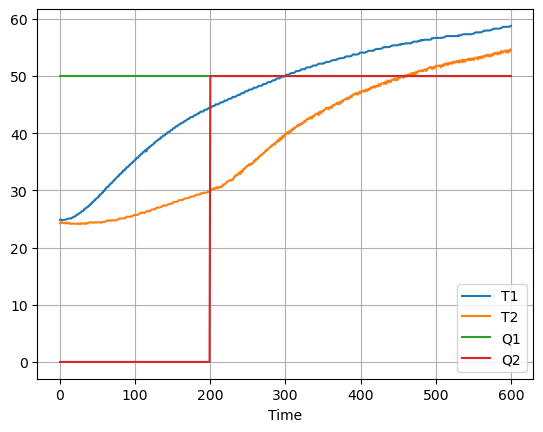

In [10]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('./data/Step_Test_Data_testing3.csv') # my data

df = df.set_index('Time')
df.plot(grid=True)

## Parameter Estimation

### Fitting the Step Change Data to a First Order Model

For a first-order linear system initially at steady-state, the response to a step input change at $t=0$ is given by

$$y(t) = y(0) + K(1 - e^{-t/\tau}) \Delta U$$

where $\Delta U$ is the magnitude of the step change. Converting to notation used for the temperature control lab where $y(t) = T_1(t)$ and $\Delta U = \Delta Q_1$

$$T_1(t) = T_1(0) + K_1(1 - e^{-t/\tau_1}) \Delta Q_1$$

the following cells provide initial estimates for the steady state gain $K_1$ and time constant $\tau_1$.

>  **Questions:**   
>- Recall the differential equation and the transfer function of a 1st order SISO (Single Input Single Output) dynamic system. Use notations compatible with the description of the step response above.  
>- Recall the differential equation and the transfer function of a 1st order SISO (Single Input Single Output) dynamic system. Use notations compatible with the description of the step response above.  



### Reading Saved Data

<AxesSubplot:xlabel='Time'>

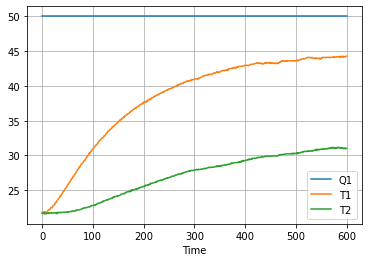

In [23]:
df[['Q1','T1','T2']].plot(grid=True)

### Estimating Gain and Time Constant

In the limit $t\rightarrow\infty$ the first order model becomes

$$T_1(\infty) = T_1(0) + K_1\Delta Q_1$$

which provides an method for estimating $K_1$

$$K_1 = \frac{T_1(\infty) - T_1(0)}{\Delta Q_1}$$

These calculations are performed below where we use the first and last measurements of $T_1$ as estimates of $T_1(0)$ and $T_1(\infty)$, respectively.

In [11]:
T1 = df['T1']
Q1 = df['Q1']

DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
print('K1 is approximately : %.2f °C/%%'%K1)

K1 is approximately : 0.45 °C/%


In [25]:
# find when the increase in T1 gets larger than 63.2% of the final increase
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()
print("tau1 is approximately", tau1, "seconds")

tau1 is approximately 170.01 seconds


Text(0.5, 1.0, 'Residual Error')

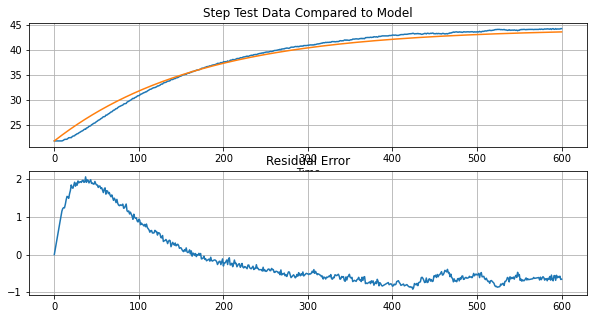

In [26]:
import matplotlib.pyplot as plt
import numpy as np

exp = np.exp
t = df.index

T1_est = T1.min() + K1*(1 - exp(-t/tau1))*DeltaQ1

plt.figure(figsize=(10,5))
ax = plt.subplot(2,1,1)
df['T1'].plot(ax = ax, grid=True)
plt.plot(t,T1_est)
plt.title('Step Test Data Compared to Model')

plt.subplot(2,1,2)
plt.plot(t,T1_est-T1)
plt.grid()
plt.title('Residual Error')

A first order model captures certain features, and provides a reasonably good result as the system approaches a new steady-state. The problem, however, is that for control we need a good model during initial transient. This is where the first-order model breaks down and predicts a qualitatively different response from what we observe.

## First Order plus Dead Time

$$T_1(t) = T_1(0) + K (1-e^\frac{t-\theta}{\tau}) Q_{step}$$

> **Question :** On ajoute ici un retard pur de temps $\theta$ à la réponse du 1er ordre. Rappeler comment s'exprime ce retard pur dans la fonction de transfert dans le domaine de Laplace.

Dans cette partie, on va interagir graphiquement ici avec les courbes pour identifier les 3 parametres caractéristiques de la réponse.  

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact

df = pd.read_csv('data/step-test-data.csv')
df = df.set_index('Time')

T1 = df['T1']
Q1 = df['Q1']
t = df.index

DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()

def fopdt(K=K1, tau=tau1, theta=0, T10=T1.min()):
    def Q1(t):
        return 0 if t < 0 else DeltaQ1
    Q1vec = np.vectorize(Q1)
    T1_fopdt = T10 + K*(1-np.exp(-(t-theta)/tau))*Q1vec(t-theta)
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(t,T1_fopdt)
    plt.plot(t,df['T1'])
    plt.subplot(2,1,2)
    plt.plot(t,T1_fopdt - T1)
    plt.show()
    
interact(fopdt,K=(0,1,.001),tau=(50,200,.5),theta=(0,50,.5),T10=(15,25,.1))

interactive(children=(FloatSlider(value=0.6968700000000001, description='K', max=1.0, step=0.001), FloatSlider…

<function __main__.fopdt(K=0.6968700000000001, tau=163.0, theta=0, T10=20.9)>

## Second Order

> **Question:** démontrer qu'une fonction de transfert du second ordre, produit de deux premiers ordres, répond à un échelon avec l'expression suivante :
$$T_1(t) = T_1(0) + K\left(1 - \frac{\tau_1 e^{-t/\tau_1} - \tau_2 e^{-t/\tau_2}}{\tau_1 - \tau_2}\right)Q_1(t)$$

On va tenter par la suite de déterminer les paramètres caractéristiques de la fonction de transfert par interaction directe avec les courbes de réponses. 

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact

df = pd.read_csv('data/step-test-data.csv') # J Kantor data
df = pd.read_csv('Step_Test_Data.csv') # my data

df = df.set_index('Time')

T1 = df['T1']
Q1 = df['Q1']
t = df.index

DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()

def secondorder(K=K1, tau1=tau1, tau2=40, T10=T1.min()):
    def Qscalar(t):
        return 0 if t < 0 else DeltaQ1
    Q = np.vectorize(Qscalar)
    exp = np.exp
    T = T10 + K*(1 - (tau1*exp(-t/tau1) - tau2*exp(-t/tau2))/(tau1-tau2))*Q(t)
    plt.subplot(2,1,1)
    plt.plot(t,T)
    plt.plot(t,df['T1'])
    plt.subplot(2,1,2)
    plt.plot(t,T1 - T)
    plt.show()
    
interact(secondorder,K=(0,1,.001),tau1=(1,200,.1),tau2=(0,200,.1),T10=(15,25,.1))

interactive(children=(FloatSlider(value=0.4477999999999999, description='K', max=1.0, step=0.001), FloatSlider…

<function __main__.secondorder(K=0.4477999999999999, tau1=170.01, tau2=40, T10=21.87)>

## Fitting a Second Order Model by Least Squares

La détermination graphique d'un nombre important de paramètres peut se révéler difficile. Il est possible de déterminer les paramètres du second ordre à l'aide de la fonction [least_square](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) qui minimise une erreur par optimisation.  

In [14]:
from scipy.optimize import least_squares
import numpy as np
Qmax = 50

def f(x):
    K,tau1,tau2,T10 = x
    t = df.index
    exp = np.exp
    Tpred = T10 + K*(1 - (tau1*exp(-t/tau1) - tau2*exp(-t/tau2))/(tau1-tau2))*Qmax
    resid = df['T1'] - Tpred
    return resid

ic = [0.86,40,130,20]

r = least_squares(f,ic,bounds=(0,np.inf))
r.x

array([  0.46130815,  21.33463346, 151.23432317,  21.65486132])

$$ G_1(s) = \frac{0.46}{(21s + 1)(151s + 1)} $$